# Shifting of Price Forwad Curves (PFCs) for Energy Markets

Toy model for the spot price for electricity:
$$
S(t) = S_0 + 
    \begin{cases}
    0 & ,0 \leq h(t) < 8\\
    P_p & ,8 \leq h(t) < 11\\
    -P_{pv} & ,11\leq h(t) < 16\\
    P_p & ,16 \leq h(t) \leq 20\\
    0 & ,20 < h(t) \leq 23
    \end{cases} +
    \begin{cases}
        0 & ,1\leq d(d) \leq 5\\
        -P_{we} & ,6\leq d(t) \leq 7
    \end{cases} +
    \begin{cases}
        0 & ,m(t) \in \{4,5,6,7,8,9\}\\
        P_{W} & ,m(t) \in \{1,2,3,10,11,12\}
    \end{cases} + \varepsilon
$$
The parameters here are:
$$
\begin{align*}
S_0 &\quad\text{Spot price level}\\
P_p & \quad\text{Peak price level}\\
P_{pv} & \quad\text{Price level with regard to solar power}\\
P_{we} & \quad\text{Price level for weekends}\\
P_W & \quad\text{Price level for winter}\\
h(t) & \quad\text{Hour of the time step $t$}\\
d(t) & \quad\text{Week day of the time step $t$}\\
m(t) & \quad\text{Month of the time step $t$}\\
\varepsilon&  \sim \mathcal{N}(\mu, \sigma^2)
\end{align*}
$$

In [154]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from rivapy.instruments.energy_futures_specifications import EnergyFutureSpecifications
from rivapy.tools.scheduler import SimpleSchedule
from rivapy.marketdata.pfc_shifter import PFCShifter
from collections import defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
np.random.seed(42)
def spot_price_model(timestamp: dt.datetime, spot_price_level: float, peak_price_level:float, solar_price_level: float,
                     weekend_price_level:float, winter_price_level: float, epsilon_mean: float = 0, epsilon_var:float = 1):
                    spot_price = spot_price_level
                    if (timestamp.hour >= 8 and timestamp.hour < 11) or (timestamp.hour >= 16 and timestamp.hour <= 20):
                            spot_price += peak_price_level
                    elif timestamp.hour >= 11 and timestamp.hour < 16:
                            spot_price -= solar_price_level
                    
                    if timestamp.weekday() >= 5:
                            spot_price -= weekend_price_level

                    if timestamp.month in {1,2,3,10,11,12}:
                            spot_price += winter_price_level 

                    spot_price += np.random.normal(loc=epsilon_mean, scale=np.sqrt(epsilon_var))
                    return spot_price

In [156]:
parameter_dict = {
    'spot_price_level': 100,
    'peak_price_level': 10,
    'solar_price_level': 8,
    'weekend_price_level': 10,
    'winter_price_level': 20,
    'epsilon_mean': 0,
    'epsilon_var': 5
}


In [157]:
date_range = pd.date_range(start='1/1/2023', end='1/1/2025', freq='H', inclusive='left')

In [158]:
spot_prices = list(map(lambda x: spot_price_model(x, **parameter_dict), date_range))

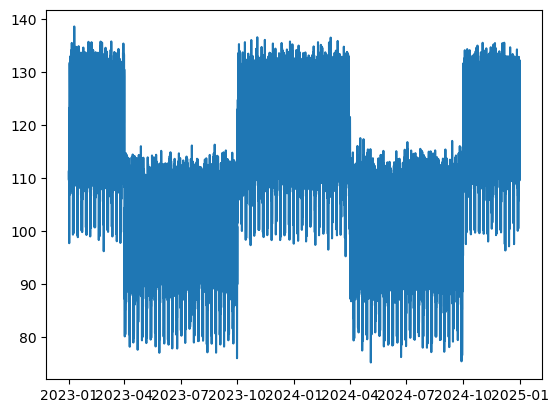

In [159]:
plt.plot(date_range, spot_prices)

In [160]:
# compute the shape 
df = pd.DataFrame(data=spot_prices, index=date_range, columns=['Spot'])
df

,Spot
2023-01-01 00:00:00,111.110687
2023-01-01 01:00:00,109.690832
2023-01-01 02:00:00,111.448276
2023-01-01 03:00:00,113.405598
2023-01-01 04:00:00,109.476417
...,...
2024-12-31 19:00:00,129.120348
2024-12-31 20:00:00,132.005100
2024-12-31 21:00:00,118.503252
2024-12-31 22:00:00,123.916270


In [161]:
base_y = df.resample('Y').mean()
base_y.index = base_y.index.strftime('%Y')

In [162]:
df_spot = df.copy()
df_spot.index = df_spot.index.strftime('%Y')
df_spot

,Spot
2023,111.110687
2023,109.690832
2023,111.448276
2023,113.405598
2023,109.476417
...,...
2024,129.120348
2024,132.005100
2024,118.503252
2024,123.916270


In [163]:
shape = df_spot.divide(base_y, axis='index')
shape_df = pd.DataFrame(data=shape['Spot'].tolist(), index=date_range, columns=['shape'])
shape_df

,shape
2023-01-01 00:00:00,1.021601
2023-01-01 01:00:00,1.008546
2023-01-01 02:00:00,1.024705
2023-01-01 03:00:00,1.042702
2023-01-01 04:00:00,1.006575
...,...
2024-12-31 19:00:00,1.186252
2024-12-31 20:00:00,1.212755
2024-12-31 21:00:00,1.088711
2024-12-31 22:00:00,1.138442


<AxesSubplot: >

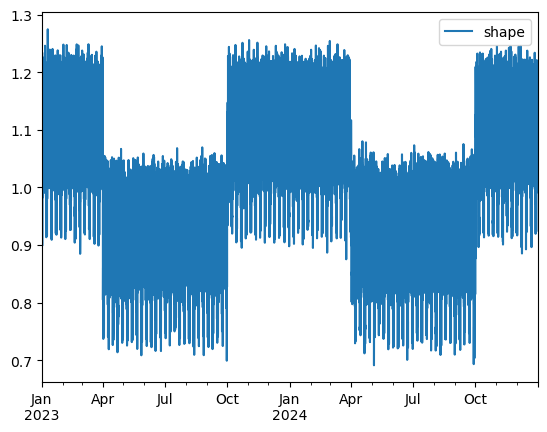

In [164]:
shape_df.plot()

In [165]:
# contracts_schedules = {
#     'Cal20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H'),
#     # 'Cal20_Peak': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H', hours=set(np.arange(8,21))),
#     # 'Cal20_OffPeak': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H', hours=set(np.arange(0,24))-set(np.arange(8,21))),
#     'Cal21_Base': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H'),
#     'Q1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,4,1), freq='1H'),
#     'Q2/20_Base': SimpleSchedule(dt.datetime(2020,4,1), dt.datetime(2020,7,1), freq='1H'),
#     'Q3/20_Base': SimpleSchedule(dt.datetime(2020,7,1), dt.datetime(2020,10,1), freq='1H'),
#     'Q4/20_Base': SimpleSchedule(dt.datetime(2020,10,1, 10), dt.datetime(2021,1,1), freq='1H'),
#     'test': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2021,1,2), freq='1H', hours=[0,1,2,3,4,5,6,7,21,22,23])
#     # 'Cal21_Peak': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(8,21))),
#     # 'Cal21_OffPeak': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(0,24))-set(np.arange(8,21)))
# }

In [166]:
contracts_schedules = {
    'off_peak': {
        'Cal23_OffPeak': SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2024,1,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'Cal24_OffPeak': SimpleSchedule(dt.datetime(2024,1,1), dt.datetime(2025,1,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'Q1/23_OffPeak': SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2023,4,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        'Q2/23_OffPeak': SimpleSchedule(dt.datetime(2023,4,1), dt.datetime(2023,7,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'Q3/23_OffPeak': SimpleSchedule(dt.datetime(2023,7,1), dt.datetime(2023,10,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'Q4/23_OffPeak': SimpleSchedule(dt.datetime(2023,10,1), dt.datetime(2024,1,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'M1/23_OffPeak': SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2023,2,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'M2/23_OffPeak': SimpleSchedule(dt.datetime(2023,2,1), dt.datetime(2023,3,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'M3/23_OffPeak': SimpleSchedule(dt.datetime(2023,3,1), dt.datetime(2023,4,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
        # 'M5/23_OffPeak': SimpleSchedule(dt.datetime(2023,5,1), dt.datetime(2023,6,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]),
    },
    'peak': {
        'Cal23_Peak': SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2024,1,1), freq='1H', hours=[8,9,10,11,12,13,14,15,16,17,18,19], weekdays=[0,1,2,3,4]),
        'Cal24_Peak': SimpleSchedule(dt.datetime(2024,1,1), dt.datetime(2025,1,1), freq='1H', hours=[8,9,10,11,12,13,14,15,16,17,18,19], weekdays=[0,1,2,3,4]),
        'Q1/23_Peak': SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2023,4,1), freq='1H', hours=[8,9,10,11,12,13,14,15,16,17,18,19], weekdays=[0,1,2,3,4]),
        'Q2/23_Peak': SimpleSchedule(dt.datetime(2023,4,1), dt.datetime(2023,7,1), freq='1H', hours=[8,9,10,11,12,13,14,15,16,17,18,19], weekdays=[0,1,2,3,4]),
        'Q3/23_Peak': SimpleSchedule(dt.datetime(2023,7,1), dt.datetime(2023,10,1), freq='1H', hours=[8,9,10,11,12,13,14,15,16,17,18,19], weekdays=[0,1,2,3,4])
    }
}

In [167]:
contracts = defaultdict(dict)
for contract_type, contracts_dict in contracts_schedules.items():
    for contract_name, schedule in contracts_dict.items():
        tg = schedule.get_schedule()
        price = df.loc[tg,:].mean()[0]
        contracts[contract_type][contract_name] = EnergyFutureSpecifications(schedule=schedule, price=price, name=contract_name)

In [168]:
dict(contracts)

{'off_peak': {'Cal23_OffPeak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef99bec8e0>,
  'Q2/23_OffPeak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef90029af0>},
 'peak': {'Cal23_Peak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef90580760>,
  'Cal24_Peak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef99bbf9d0>,
  'Q1/23_Peak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef905af790>,
  'Q2/23_Peak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef99b97580>,
  'Q3/23_Peak': <rivapy.instruments.energy_futures_specifications.EnergyFutureSpecifications at 0x1ef9a3fd4c0>}}

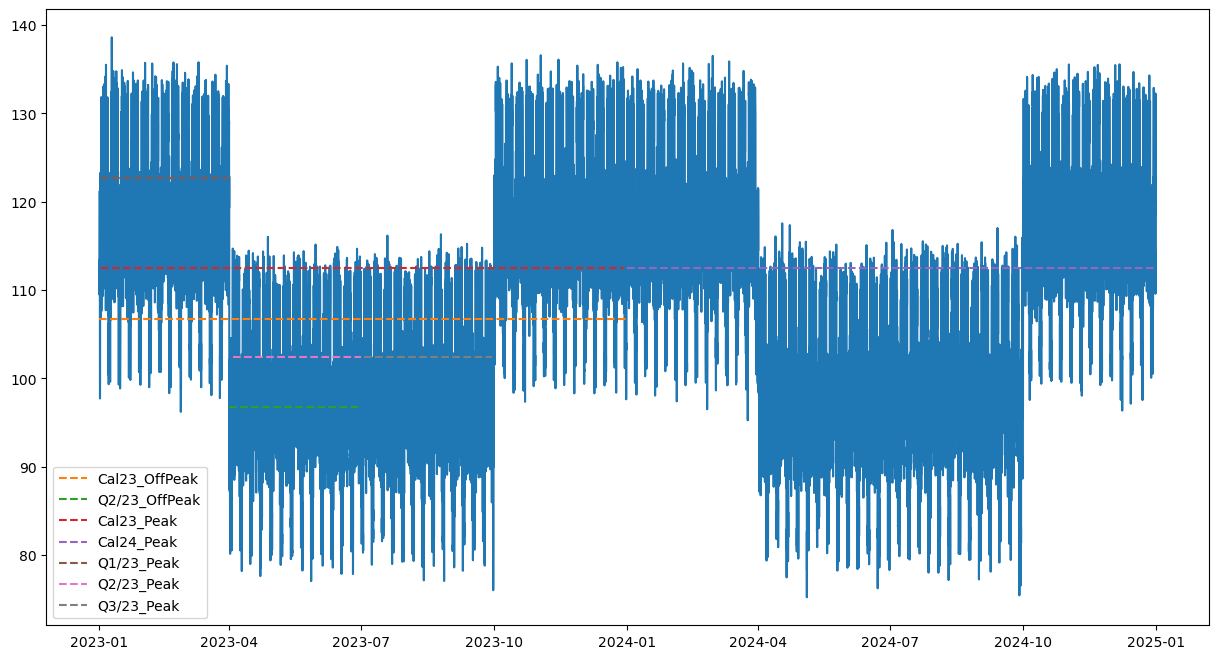

In [169]:
plt.figure(figsize=(15,8))
plt.plot(date_range, spot_prices)
ax = plt.gca()
for contract_type, contract_dict in contracts.items():
    for name, contract in contract_dict.items():
        y_value = contract.price  # The y-coordinate for the horizontal line
        x_range = contract.schedule.get_schedule()  # List of datetime values
        
        # Extract the minimum and maximum dates from the x_range
        xmin = min(x_range)
        xmax = max(x_range)
        
        # Plot a horizontal line for the contract
        color = next(ax._get_lines.prop_cycler)['color']
        plt.hlines(y=y_value, xmin=xmin, xmax=xmax, linestyle='--', label=name, colors=color)

plt.legend()
plt.show()

In [170]:
shape_df

,shape
2023-01-01 00:00:00,1.021601
2023-01-01 01:00:00,1.008546
2023-01-01 02:00:00,1.024705
2023-01-01 03:00:00,1.042702
2023-01-01 04:00:00,1.006575
...,...
2024-12-31 19:00:00,1.186252
2024-12-31 20:00:00,1.212755
2024-12-31 21:00:00,1.088711
2024-12-31 22:00:00,1.138442


In [171]:
shape_df_off_peak = shape_df.loc[SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2024,1,1), freq='1H', hours=[0,1,2,3,4,5,6,7,20,21,22,23], ignore_hours_for_weekdays=[5,6]).get_schedule()]
shape_df_peak = shape_df.loc[SimpleSchedule(dt.datetime(2023,1,1), dt.datetime(2025,1,1),freq='1H', hours=[8,9,10,11,12,13,14,15,16,17,18,19], weekdays=[0,1,2,3,4]).get_schedule()]

In [172]:
shape_df_off_peak

,shape
2023-01-01 00:00:00,1.021601
2023-01-01 01:00:00,1.008546
2023-01-01 02:00:00,1.024705
2023-01-01 03:00:00,1.042702
2023-01-01 04:00:00,1.006575
...,...
2023-12-31 19:00:00,1.129429
2023-12-31 20:00:00,1.093109
2023-12-31 21:00:00,1.017435
2023-12-31 22:00:00,1.014747


In [173]:
pfc_shifter = PFCShifter(shape=shape_df_off_peak, contracts=contracts['off_peak'])

In [174]:
pfc_shifter

In [175]:
pfc_shifter.shape

,shape
2023-01-01 00:00:00,1.021601
2023-01-01 01:00:00,1.008546
2023-01-01 02:00:00,1.024705
2023-01-01 03:00:00,1.042702
2023-01-01 04:00:00,1.006575
...,...
2023-12-31 19:00:00,1.129429
2023-12-31 20:00:00,1.093109
2023-12-31 21:00:00,1.017435
2023-12-31 22:00:00,1.014747


In [176]:
pfc_shifter._get_contract_start_end_dates()

[datetime.datetime(2023, 1, 1, 0, 0),
 datetime.datetime(2023, 4, 1, 0, 0),
 datetime.datetime(2023, 7, 1, 0, 0),
 datetime.datetime(2024, 1, 1, 0, 0)]

In [193]:
transition_matrix=pfc_shifter.generate_transition_matrix()
transition_matrix

,2023-01-01,2023-04-01,2023-07-01
Cal23_OffPeak,1.0,1.0,1.0
Q2/23_OffPeak,0.0,1.0,0.0


In [194]:
transition_matrix = pfc_shifter.detect_redundant_contracts(transition_matrix=transition_matrix)
transition_matrix

,2023-01-01,2023-04-01,2023-07-01
Cal23_OffPeak,1.0,1.0,1.0
Q2/23_OffPeak,0.0,1.0,0.0


In [195]:
pfc_shifter._get_contract_start_end_dates()

[datetime.datetime(2023, 1, 1, 0, 0),
 datetime.datetime(2023, 4, 1, 0, 0),
 datetime.datetime(2023, 7, 1, 0, 0),
 datetime.datetime(2024, 1, 1, 0, 0)]

In [196]:
transition_matrix = pfc_shifter.generate_synthetic_contracts(transition_matrix=transition_matrix)
transition_matrix

c:\Users\Anwender\anaconda3\envs\rivapy\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,2023-01-01,2023-04-01,2023-07-01
Cal23_OffPeak,1.0,1.0,1.0
Q2/23_OffPeak,0.0,1.0,0.0
Synth_Con_1,1.0,0.0,0.0


In [198]:
shifted = pfc_shifter.shift(transition_matrix)
shifted

[1380 1404 2856]
[5640. 1404. 1380.]
[(datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 4, 1, 0, 0)), (datetime.datetime(2023, 4, 1, 0, 0), datetime.datetime(2023, 7, 1, 0, 0)), (datetime.datetime(2023, 7, 1, 0, 0), datetime.datetime(2024, 1, 1, 0, 0))]


,shape
2023-01-01 00:00:00,111.110687
2023-01-01 01:00:00,109.690832
2023-01-01 02:00:00,111.448276
2023-01-01 03:00:00,113.405598
2023-01-01 04:00:00,109.476417
...,...
2023-12-31 19:00:00,122.838142
2023-12-31 20:00:00,118.887965
2023-12-31 21:00:00,110.657587
2023-12-31 22:00:00,110.365227


In [199]:
df.loc[shifted.index, :]

,Spot
2023-01-01 00:00:00,111.110687
2023-01-01 01:00:00,109.690832
2023-01-01 02:00:00,111.448276
2023-01-01 03:00:00,113.405598
2023-01-01 04:00:00,109.476417
...,...
2023-12-31 19:00:00,122.838142
2023-12-31 20:00:00,118.887965
2023-12-31 21:00:00,110.657587
2023-12-31 22:00:00,110.365227


In [132]:
# relative error
rel_err = (spot_prices-shifted.iloc[:,0])/spot_prices
plt.plot(rel_err)
plt.tight_layout()

ValueError: operands could not be broadcast together with shapes (17544,) (4015,) 

# Synthetic Contracts

In [132]:
contracts_schedules_synthetic = {
    'Cal20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H'),
    'Cal21_Base': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H'),
    'Q1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,4,1), freq='1H'),
    'Q2/20_Base': SimpleSchedule(dt.datetime(2020,4,1), dt.datetime(2020,7,1), freq='1H'),
    'Q3/20_Base': SimpleSchedule(dt.datetime(2020,7,1), dt.datetime(2020,10,1), freq='1H'),
    'Q4/20_Base': SimpleSchedule(dt.datetime(2020,10,1), dt.datetime(2021,1,1), freq='1H'),
    'M1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,2,1), freq='1H'),
    'Sum/21_Base': SimpleSchedule(dt.datetime(2021,4,1), dt.datetime(2021,10,1), freq='1H')
    
}

In [133]:
contracts_synth = {}
for contract_name, schedule in contracts_schedules_synthetic.items():
    tg = schedule.get_schedule()
    price = df.loc[tg,:].mean()[0]
    contracts_synth[contract_name] = EnergyFutureSpecifications(schedule=schedule, price=price, name=contract_name)

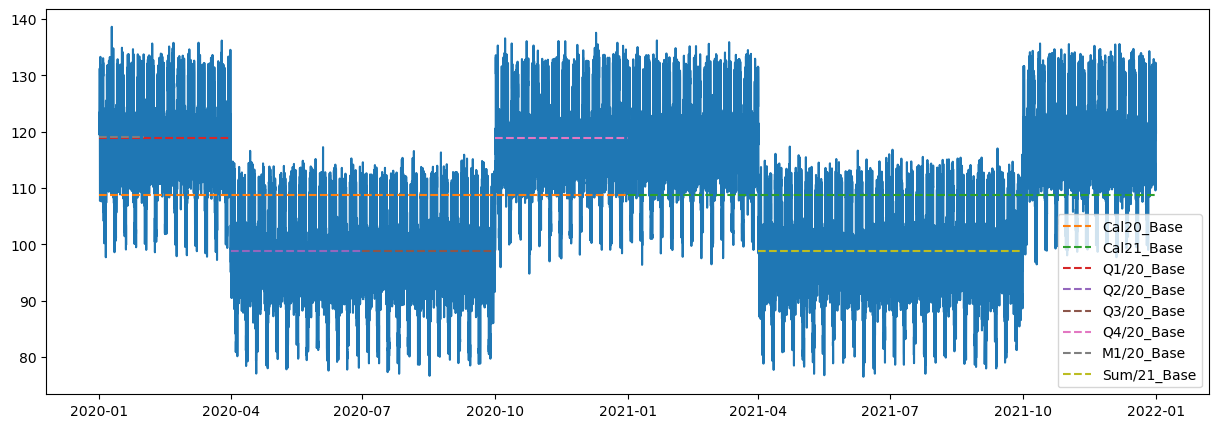

In [134]:
plt.figure(figsize=(15,5))
plt.plot(date_range, spot_prices)
ax = plt.gca()
for name, contract in contracts_synth.items():
    y_value = contract.price  # The y-coordinate for the horizontal line
    x_range = contract.schedule.get_schedule()  # List of datetime values
    
    # Extract the minimum and maximum dates from the x_range
    xmin = min(x_range)
    xmax = max(x_range)
    
    # Plot a horizontal line for the contract
    color = next(ax._get_lines.prop_cycler)['color']
    plt.hlines(y=y_value, xmin=xmin, xmax=xmax, linestyle='--', label=name, colors=color)

plt.legend()
plt.show()

In [135]:
pfc_shifter_synth = PFCShifter(shape=shape_df, contracts=contracts_synth)

In [136]:
transition_matrix_synth=pfc_shifter_synth.generate_transition_matrix()
transition_matrix_synth

,2020-01-01,2020-02-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01,2021-04-01,2021-10-01
Cal20_Base,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Cal21_Base,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Q1/20_Base,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Q2/20_Base,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Q3/20_Base,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Q4/20_Base,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
M1/20_Base,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sum/21_Base,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [131]:
transition_matrix_synth = pfc_shifter_synth.detect_redundant_contracts(transition_matrix=transition_matrix_synth)
transition_matrix_synth

Found redundant contract: Cal20_Base2
Found redundant contract: Q4/20_Base


,2020-01-01,2020-02-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01,2021-04-01,2021-10-01
Cal20_Base,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Cal21_Base,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Q1/20_Base,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Q2/20_Base,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Q3/20_Base,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
M1/20_Base,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sum/21_Base,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [73]:
# since we found a redundant contract the new transitions matrix is not quadratic anymore
transition_matrix_synth.shape

(7, 8)

In [74]:
transition_matrix_synth.iloc[:, -3] == transition_matrix_synth.iloc[:, -1]

Cal20_Base     True
Cal21_Base     True
Q1/20_Base     True
Q2/20_Base     True
Q3/20_Base     True
M1/20_Base     True
Sum/21_Base    True
dtype: bool

In [46]:
new_arr = np.array([dt.datetime(2024,1,1),dt.datetime(2024,1,2),dt.datetime(2024,1,3)])

In [47]:
arr = np.array([dt.datetime(2024,1,1),dt.datetime(2024,1,1,12), dt.datetime(2024,1,3)])

In [48]:
np.searchsorted(arr, new_arr, side='left')

array([0, 2, 2], dtype=int64)

In [49]:
np.searchsorted(arr, new_arr, side='right')

array([1, 2, 3], dtype=int64)